
# Getting data from CDAWeb

*Really nice, much cleaner and faster than before, both downloading and importing. Now, introduce it into 1_compute_sfs, just noting annoying issue with variable names.

Using Sunpy to download data from CDAWeb using its Fido interface. To lookup the different dataset IDs available, you can use the form at https://cdaweb.gsfc.nasa.gov/index.html/
Tick the name of the spacecraft you want, hit submit, and you'll be a given a list of all the data products for that spacecraft. Copy and paste the name into the `a.cdaweb.Dataset("")` below, choose your time range `trange`, and you're away!

## Data download

In [1]:
import glob
import re
import plotly.express as px
import pandas as pd


from sunpy.net import Fido


from sunpy.net import attrs as a


from sunpy.timeseries import TimeSeries

In [2]:
# "WI_H2_MFI"
# "PSP_FLD_L2_MAG_RTN"
# "VOYAGER1_48S_MAG-VIM"

V1 from 2013, V2 from 2019
**13 years of data: V2 2019-2022, V1: 2013-2023 (missing 2019,2020)**

In [3]:
trange = a.Time("2017-01-01 00:00", "2019-01-01 00:00")
dataset = a.cdaweb.Dataset("VOYAGER2_48S_MAG-VIM")
result = Fido.search(trange, dataset)
print(result)

Results from 1 Provider:

2 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

      Dataset               Start time               End time       
-------------------- ----------------------- -----------------------
VOYAGER2_48S_MAG-VIM 2017-01-01 03:12:30.000 2017-12-30 20:08:40.000
VOYAGER2_48S_MAG-VIM 2018-01-01 16:05:29.000 2018-12-31 19:42:21.000




Datasets are 6-hourly

In [4]:
downloaded_files = Fido.fetch(result[0], path="../data/raw/voyager/")
print(downloaded_files)

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

['..\\data\\raw\\voyager\\voyager2_48s_mag-vim_20170101_v01.cdf', '..\\data\\raw\\voyager\\voyager2_48s_mag-vim_20180101_v01.cdf']


## Data reading

Takes 2min to read 15 Voyager files (1 year each)

In [5]:
# Get list of all Voyager 1 files in directory
v1_file_list = glob.glob("../data/raw/voyager/voyager1*")
v2_file_list = glob.glob("../data/raw/voyager/voyager2*")

v1 = TimeSeries(v1_file_list, concatenate=True)
v2 = TimeSeries(v2_file_list, concatenate=True)

# data.columns


# data.units


# data.meta


# data.quicklook()  # Fun!

# data.truncate("2023/02/01 00:00", "2023/02/07 00:00").peek(columns=data.columns[0:3])

In [6]:
# Extract the year from the first file in file_list (ow for some reason timestamp went back to 1993)
v1_start_year = re.search(r"(\d{4})", v1_file_list[0]).group(1)
v2_start_year = re.search(r"(\d{4})", v2_file_list[0]).group(1)

v1_df_raw = v1.to_dataframe()[v1_start_year:]
v2_df_raw = v2.to_dataframe()[v2_start_year:]

# Calculate the cadence of the time series


modal_cadence = v1_df_raw.index.to_series().diff().mode()[0]
modal_cadence

Timedelta('0 days 00:00:47.520000')

In [7]:
preset_cadence = "24h"
v1_df = v1_df_raw.resample(preset_cadence).mean()
v2_df = v2_df_raw.resample(preset_cadence).mean()

v1_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5478 entries, 2009-01-01 to 2023-12-31
Freq: 24h
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BN            5249 non-null   float32
 1   BR            5249 non-null   float32
 2   BT            5249 non-null   float32
 3   F1            5249 non-null   float32
 4   dBN           5249 non-null   float32
 5   dBR           5249 non-null   float32
 6   dBT           5249 non-null   float32
 7   dF            5249 non-null   float32
 8   spacecraftID  5249 non-null   float64
 9   Radius        5456 non-null   float32
 10  hg_lat        5456 non-null   float32
 11  hg_lon        5456 non-null   float32
 12  hgi_lon       5456 non-null   float32
dtypes: float32(12), float64(1)
memory usage: 342.4 KB


In [8]:
v2_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2191 entries, 2017-01-01 to 2022-12-31
Freq: 24h
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BN            2102 non-null   float32
 1   BR            2102 non-null   float32
 2   BT            2102 non-null   float32
 3   F1            2102 non-null   float32
 4   dBN           2102 non-null   float32
 5   dBR           2102 non-null   float32
 6   dBT           2102 non-null   float32
 7   dF            2102 non-null   float32
 8   spacecraftID  2102 non-null   float64
 9   Radius        2191 non-null   float32
 10  hg_lat        2191 non-null   float32
 11  hg_lon        2191 non-null   float32
 12  hgi_lon       2191 non-null   float32
dtypes: float32(12), float64(1)
memory usage: 136.9 KB


In [9]:
missing = v2_df.iloc[:, 0].isna().sum() / len(v2_df)
missing

0.040620721131903244

In [10]:
# Add a rectangle highlighting certain period
# First, convert DOY to date
def create_highlight_region(name, doy_start, year_start, doy_end, year_end):
    date_start = pd.to_datetime(f"{year_start}-01-01") + pd.DateOffset(
        days=doy_start - 1
    )
    date_end = pd.to_datetime(f"{year_end}-01-01") + pd.DateOffset(days=doy_end - 1)
    fig.add_vrect(
        annotation_text=name,
        x0=date_start,
        x1=date_end + pd.DateOffset(days=1),
        fillcolor="grey",
        opacity=0.25,
        line_width=0,
    )

In [ ]:
import datetime

v1_hp_date = "2012-08-25"
v1_end_date = v1_df.index[-1]

v1_time_diff = v1_end_date - pd.to_datetime(v1_hp_date)

fig = px.line(
    v1_df[["F1", "BR", "BT", "BN"]],
    title="Magnetic Field Components",
    color_discrete_map={"F1": "black", "BR": "red", "BT": "green", "BN": "blue"},
)



match = re.search(r"voyager(\d)", v1_file_list[0], re.IGNORECASE)



if match:

    spacecraft_name = f"Voyager {match.group(1)}"



else:

    spacecraft_name = "Voyager"



fig.update_layout(
    xaxis_title="Date",
    yaxis_title="B (nT)",
    title=f"{spacecraft_name} Magnetic Field Components, {preset_cadence} cadence, with intervals studied in Fraternale et al. (2019, 2021)",
    legend_title="Component",
)



fig.add_vline(
    # x="2012-08-25",
    x=datetime.datetime.strptime(v1_hp_date, "%Y-%m-%d").timestamp()
    * 1000,  # work-around for bug in plotly
    annotation_text="Heliopause",
    annotation_position="bottom right",
    annotation_font_size=15,
)
# Add annotation "sh1" at the top of the line
fig.add_annotation(
    x=pd.to_datetime("2012-01-01") + pd.DateOffset(days=335 - 1),
    y=max(v1_df[["F1", "BR", "BT", "BN"]].max()),
    text="sh1",
)


fig.add_annotation(
    x=pd.to_datetime("2014-01-01") + pd.DateOffset(days=236 - 1),
    y=max(v1_df[["F1", "BR", "BT", "BN"]].max()),
    text="sh2",
)

fig.add_annotation(
    x=pd.to_datetime("2016-01-01") + pd.DateOffset(days=346 - 1),
    y=max(v1_df[["F1", "BR", "BT", "BN"]].max()),
    text="pf1",
)

fig.add_annotation(
    x=pd.to_datetime("2020-01-01") + pd.DateOffset(days=147 - 1),
    y=max(v1_df[["F1", "BR", "BT", "BN"]].max()),
    text="pf2",
)

create_highlight_region("I1", 131, 2013, 176, 2014)
create_highlight_region("I2", 184, 2014, 141, 2015)
create_highlight_region("I3", 220, 2015, 294, 2016)
create_highlight_region("Z3", int(0.7178 * 365), 2017, int(0.9973 * 365), 2018)
create_highlight_region("I4", 16, 2017, 272, 2017)
create_highlight_region("I5", 1, 2018, 365, 2018)


create_highlight_region("H1", 1, 2020, 146, 2020)



create_highlight_region("H2", 1, 2021, 365, 2021)

fig.update_xaxes(
    range=[
        pd.to_datetime(v1_hp_date) + pd.DateOffset(years=-2),
        pd.to_datetime(v1_hp_date) + v1_time_diff,
    ]
)


fig.show()

In [ ]:
v2_hp_date = "2018-11-05"

fig = px.line(
    v2_df[["F1", "BR", "BT", "BN"]],
    title="Magnetic Field Components",
    color_discrete_map={"F1": "black", "BR": "red", "BT": "green", "BN": "blue"},
)



fig.update_layout(
    xaxis_title="Date",
    yaxis_title="B (nT)",
    title=f"{spacecraft_name} Magnetic Field Components, {preset_cadence} cadence, with intervals studied in Fraternale et al. (2019, 2021)",
    legend_title="Component",
)



# Add a vertical line at 25 August 2012


fig.add_vline(
    x=datetime.datetime.strptime(v2_hp_date, "%Y-%m-%d").timestamp()
    * 1000,  # work-around for bug in plotly
    annotation_text="Heliopause",
    annotation_position="bottom right",
    annotation_font_size=15,
)

# Set the x-axis range to be the same as the Voyager 1 plot
fig.update_xaxes(
    range=[
        pd.to_datetime(v2_hp_date) + pd.DateOffset(years=-2),
        pd.to_datetime(v2_hp_date) + v1_time_diff,
    ]
)
fig.show()

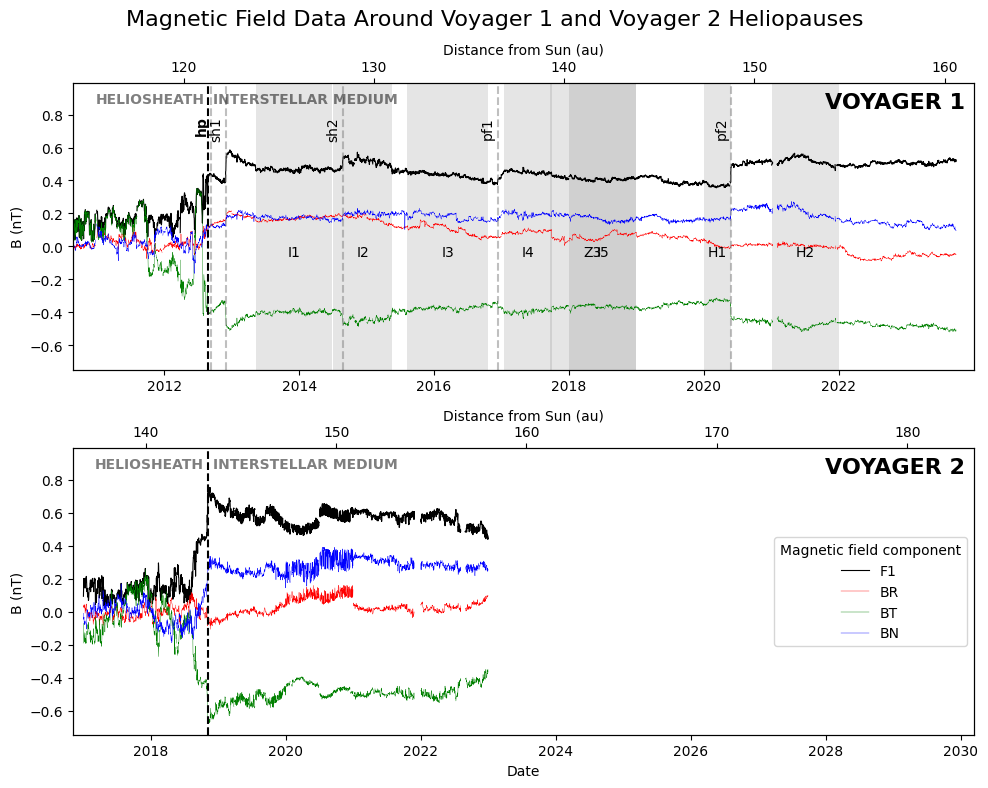

In [238]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime


# Updated function: if doy_end and year_end are not provided, plot a single vertical line.
def create_highlight_region(
    ax,
    name,
    doy_start,
    year_start,
    doy_end=None,
    year_end=None,
    color="grey",
):
    # Compute the base date from the start parameters.
    date = pd.to_datetime(f"{year_start}-01-01") + pd.DateOffset(days=doy_start - 1)
    ylim = ax.get_ylim()
    if doy_end is None or year_end is None:
        # Plot a single vertical line at the specified date.
        ax.axvline(date, color=color, linestyle="--", alpha=0.5, label=name)
        # Place a label near the top of the line.
        ax.text(
            date - pd.DateOffset(days=90),
            ylim[1] * 0.8,
            name,
            rotation=90,
            verticalalignment="top",
            fontsize=10,
        )
    else:
        # Compute the end date.
        date_start = date
        date_end = pd.to_datetime(f"{year_end}-01-01") + pd.DateOffset(days=doy_end - 1)
        # Plot a shaded region between the start and end dates.
        ax.axvspan(date_start, date_end, color=color, alpha=0.2, label=name, lw=0)
        # Place the label in the center of the region.
        mid_date = date_start + (date_end - date_start) / 2
        ax.text(
            mid_date,
            ylim[1] * 0.01,
            name,
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
        )


# Load Voyager 1 and 2 DataFrames (v1_df, v2_df) here

# Define key dates
v1_hp_date = pd.to_datetime("2012-08-25")
v2_hp_date = pd.to_datetime("2018-11-05")
v1_end_date = v1_df.index[-1]
v1_time_diff = v1_end_date - v1_hp_date

# Create figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharey=True)
ax1, ax2 = axes

# Plot Voyager 1 data
for component, color, lw in zip(
    ["F1", "BR", "BT", "BN"], ["black", "red", "green", "blue"], [0.8, 0.3, 0.3, 0.3]
):
    ax1.plot(v1_df.index, v1_df[component], label=component, color=color, lw=lw)
ax1.axvline(v1_hp_date, color="k", linestyle="--", label="Heliopause")
ax1.set_ylabel("B (nT)")


# Add bold capitalized annotation in the top right corner
ax1.annotate(
    "VOYAGER 1",
    xy=(0.99, 0.9),
    xycoords="axes fraction",
    fontsize=16,
    fontweight="bold",
    ha="right",
    va="bottom",
)

# Plot Voyager 2 data
for component, color, lw in zip(
    ["F1", "BR", "BT", "BN"], ["black", "red", "green", "blue"], [0.8, 0.3, 0.3, 0.3]
):
    ax2.plot(v2_df.index, v2_df[component], label=component, color=color, lw=lw)
ax2.axvline(v2_hp_date, color="k", linestyle="--")

# Add bold capitalized annotation in the top right corner
ax2.annotate(
    "VOYAGER 2",
    xy=(0.99, 0.9),
    xycoords="axes fraction",
    fontsize=16,
    fontweight="bold",
    ha="right",
    va="bottom",
)
# Add annotations "HELIOSHEATH", "INTERSTELLAR MEDIUM" pre- and post- heliopause
ax1.annotate(
    "HELIOSHEATH",
    xy=(v1_hp_date - pd.DateOffset(months=20), 0.92),
    xycoords=("data", "axes fraction"),
    fontsize=10,
    fontweight="bold",
    ha="left",
    va="bottom",
    alpha=0.5,
)
ax1.annotate(
    "INTERSTELLAR MEDIUM",
    xy=(v1_hp_date + pd.DateOffset(days=30), 0.92),
    xycoords=("data", "axes fraction"),
    fontsize=10,
    fontweight="bold",
    ha="left",
    va="bottom",
    alpha=0.5,
)

ax2.annotate(
    "HELIOSHEATH",
    xy=(v2_hp_date - pd.DateOffset(months=20), 0.92),
    xycoords=("data", "axes fraction"),
    fontsize=10,
    fontweight="bold",
    ha="left",
    va="bottom",
    alpha=0.5,
)
ax2.annotate(
    "INTERSTELLAR MEDIUM",
    xy=(v2_hp_date + pd.DateOffset(days=30), 0.92),
    xycoords=("data", "axes fraction"),
    fontsize=10,
    fontweight="bold",
    ha="left",
    va="bottom",
    alpha=0.5,
)


ax2.set_ylabel("B (nT)")
ax2.set_xlabel("Date")
ax2.legend(title="Magnetic field component", loc="center right")

# Set the y-axis upper limit to make room for the annotation
ax2.set_ylim(top=ax2.get_ylim()[1] * 1.2)


# Align the x-axis for both plots
ax1.set_xlim([v1_hp_date + pd.DateOffset(years=-2), v1_hp_date + v1_time_diff])
ax2.set_xlim([v2_hp_date + pd.DateOffset(years=-2), v2_hp_date + v1_time_diff])


# Add highlight regions for Voyager 1
highlight_regions = [
    ("I1", 131, 2013, 176, 2014),
    ("I2", 184, 2014, 141, 2015),
    ("I3", 220, 2015, 294, 2016),
    ("Z3", int(0.7178 * 365), 2017, int(0.9973 * 365), 2018),
    ("I4", 16, 2017, 272, 2017),
    ("I5", 1, 2018, 365, 2018),
    ("H1", 1, 2020, 146, 2020),
    ("H2", 1, 2021, 365, 2021),
    ("sh1", 335, 2012),
    ("sh2", 236, 2014),
    ("pf1", 346, 2016),
    ("pf2", 147, 2020),
    (r"$\mathbf{hp}$", 252, 2012),
]
for region in highlight_regions:
    create_highlight_region(ax1, *region)


# Add secondary x-axis in units of AU
# ax1_sec = ax1.secondary_xaxis(
#     "top", functions=(decimal_year_to_distance, distance_to_decimal_year)
# )
# ax1_sec.set_xlabel("Distance from Sun (AU)")
ax1_sec = add_distance_axis(ax1)
ax2_sec = add_distance_axis(ax2)

plt.suptitle(
    "Magnetic Field Data Around Voyager 1 and Voyager 2 Heliopauses", fontsize=16
)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.ticker import FuncFormatter
from datetime import datetime


# Functions for converting between timestamp, decimal year, and distance
def timestamp_to_decimal_year(timestamp):
    """Convert a pandas timestamp to decimal year"""
    year = timestamp.year
    days_in_year = (
        366 if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0) else 365
    )
    day_of_year = timestamp.dayofyear
    decimal_year = year + (day_of_year - 1) / days_in_year
    return decimal_year


def decimal_year_to_distance(decimal_year):
    # Slope and constant are the results of linear fit to following points from FratEA (2021):
    # 2013.36 = 124au
    # 2019.0 = 144au
    distance = 3.546 * decimal_year - 7015.574
    return distance


def distance_to_decimal_year(distance):
    decimal_year = (distance + 7015.574) / 3.546
    return decimal_year


def decimal_year_to_timestamp(decimal_year):
    """Convert decimal year to timestamp"""
    year = int(decimal_year)
    fraction = decimal_year - year
    days_in_year = (
        366 if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0) else 365
    )
    day_of_year = int(fraction * days_in_year) + 1
    return pd.Timestamp(year, 1, 1) + pd.Timedelta(days=day_of_year - 1)


def add_distance_axis(ax, num_ticks=5, round_to=10):
    """
    Add a secondary axis with nicely rounded distance values

    Parameters:
    -----------
    ax : matplotlib axis
        The primary axis
    num_ticks : int
        Approximate number of ticks desired
    round_to : int
        Round distance values to multiples of this number
    """
    # Create a secondary x-axis
    ax2 = ax.twiny()

    # Get the date limits from the primary axis
    date_min, date_max = mdates.num2date(ax.get_xlim())

    # Convert to decimal years
    dec_year_min = timestamp_to_decimal_year(pd.Timestamp(date_min))
    dec_year_max = timestamp_to_decimal_year(pd.Timestamp(date_max))

    # Convert to distances
    dist_min = decimal_year_to_distance(dec_year_min)
    dist_max = decimal_year_to_distance(dec_year_max)

    # Create nice, round distance values
    dist_min_rounded = np.ceil(dist_min / round_to) * round_to
    dist_max_rounded = np.floor(dist_max / round_to) * round_to

    # Generate evenly spaced distance ticks
    distance_ticks = np.linspace(dist_min_rounded, dist_max_rounded, num_ticks)

    # Convert distances back to decimal years
    dec_years = [distance_to_decimal_year(dist) for dist in distance_ticks]

    # Convert decimal years to timestamps
    tick_dates = [decimal_year_to_timestamp(dy) for dy in dec_years]

    # Convert timestamps to matplotlib date numbers
    tick_positions = [mdates.date2num(date) for date in tick_dates]

    # Set the tick positions and labels
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels([f"{dist:.0f}" for dist in distance_ticks])

    # Share the limits with the primary axis
    ax2.set_xlim(ax.get_xlim())

    # Set the label for the secondary axis
    ax2.set_xlabel("Distance from Sun (au)")

    return ax2


# Example usage (assuming 'ax' is your existing axis):
# ax2 = add_distance_axis(ax, num_ticks=6, round_to=10)

In [196]:
def distance_to_decimal_year(distance):
    # Reverse the equation to find decimal_year
    decimal_year = (distance + 7015.574) / 3.546
    return decimal_year


def decimal_year_to_distance(decimal_year):
    # Convert decimal_year to distance
    distance = 3.546 * decimal_year - 7015.574
    return distance

Quiet intervals 
- I1 (Frat 2021) = interval 1 (Zhao 2020) = L2 (Frat 2019)
- I3 (Frat 2021) = interval 2 (Zhao 2019) = L4 (Frat 2019)

In [40]:
# Create outlier filter based on moving variance calculation

import numpy as np

window = 5
threshold = 6
df["BN_std"] = df["BN"].rolling(window=window, min_periods=1).std()
df["BN_mean"] = df["BN"].rolling(window=window, min_periods=1).mean()
df["BN_outlier"] = np.abs(df["BN"] - df["BN_mean"]) > threshold * df["BN_std"]

fig = px.line(
    df[["BN", "BN_mean", "BN_std"]],
    title="Magnetic Field Component BN with Outlier Detection",
)

fig.add_scatter(
    x=df.index[df["BN_outlier"]],
    y=df["BN"][df["BN_outlier"]],
    mode="markers",
    marker=dict(color="red"),
    name="Outliers",
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="B (nT)",
    # title=f"{spacecraft_name} Magnetic Field Component BN with Outlier Detection",
    legend_title="Component",
)

fig.show()

NameError: name 'df' is not defined